## =AVG Model=

# Imports

In [19]:
import itertools
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
import tensorflow as tf
keras = tf.keras
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [20]:
path = './data/neo_full.csv'
data = pd.read_csv(path)
del data['name']
del data['date']
data.head()

price     volume   marketCap  twitterFollowers  redditAveragePosts48h  \
0  30.763900   49637713  1538194980             65687                      3   
1  30.957925   21438821  1547896236             66436                      3   
2  23.023138  143111765  1151156917             67419                      3   
3  23.674946   53125834  1183747315             68640                      3   
4  21.515456   46065917  1075772788             70173                      2   

   redditAverageComments48h  redditSubscribers  redditAccountsActive48h  \
0                       136              22013                      703   
1                       123              22277                      580   
2                       127              22821                      963   
3                       171              23713                     1309   
4                       165              24351                     1097   

   telegramChanelUserCount  alexaRank  bingMatches  forks  stars  subscribers  \
0                        0      39974            0    279    799          208   
1                        0      39580            0    281    805          209   
2                        0      39065            0    281    809          209   
3                        0      38513            0    282    812          209   
4                        0      37837            0    284    816          210   

   totalIssues  closedIssues  pullRequestsMerged  pullRequestContributors  \
0           39            32                   0                       10   
1           39            32                   0                       10   
2           39            32                   0                       10   
3           39            32                   0                       10   
4           40            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  
0                 0                0                 19  
1                 0                0                 19  
2                 0                0                 19  
3                 0                0                 20  
4                 0                0                 20

# Preprocessing

In [21]:
zero_cleaner_features =['twitterFollowers','redditSubscribers','forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues','pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
features =['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
        'alexaRank', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']

def zero_cleaner(column):
    up =0
    for i in range(len(column)):
        val = column[i]
        if column[i] == 0 and up ==0 and i >=1:
            up = column[i-1]
        if column[i] != 0 and up!=0:
            j=i
            ave = (column[i]+up)/2
            while j>=1 and column[j-1] ==0:
                column[j-1] = ave
                j-=1
            up = 0

def target_generator(data):
    b = data['price']
    in_days = 1
    target = 'price_in_{}_day'.format(in_days)
    data[target] = data['price']
    a = data[target]
    for i in range(len(b)):
        if i<len(b)-in_days:
            a[i] = b[i+in_days]
        else:
            a[i] = b[i-5:i].mean()
               
def cleaner(data):
    for feature in zero_cleaner_features:
        zero_cleaner(data[feature])
    target_generator(data) 

In [22]:
cleaner(data)               
data.head()

price     volume   marketCap  twitterFollowers  redditAveragePosts48h  \
0  30.763900   49637713  1538194980             65687                      3   
1  30.957925   21438821  1547896236             66436                      3   
2  23.023138  143111765  1151156917             67419                      3   
3  23.674946   53125834  1183747315             68640                      3   
4  21.515456   46065917  1075772788             70173                      2   

   redditAverageComments48h  redditSubscribers  redditAccountsActive48h  \
0                       136              22013                      703   
1                       123              22277                      580   
2                       127              22821                      963   
3                       171              23713                     1309   
4                       165              24351                     1097   

   telegramChanelUserCount  alexaRank  bingMatches  forks  stars  subscribers  \
0                        0      39974            0    279    799          208   
1                        0      39580            0    281    805          209   
2                        0      39065            0    281    809          209   
3                        0      38513            0    282    812          209   
4                        0      37837            0    284    816          210   

   totalIssues  closedIssues  pullRequestsMerged  pullRequestContributors  \
0           39            32                   0                       10   
1           39            32                   0                       10   
2           39            32                   0                       10   
3           39            32                   0                       10   
4           40            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  price_in_1_day  
0                 0                0                 19       30.957925  
1                 0                0                 19       23.023138  
2                 0                0                 19       23.674946  
3                 0                0                 20       21.515456  
4                 0                0                 20       30.842616

# Train

In [23]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape

    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))

    return X_train, X_test

def split_train_test(data, window):
    amount_of_features = len(data.columns)
    data = data.values
    sequence_length = window + 1
    result = []
    to_predict = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
        # we should minus window size but because we need same shapes to scale, we minus seq_length and then cut the firs later
    to_predict.append(data[len(data) - sequence_length: len(data)])


    result = np.array(result)
    to_predict = np.array(to_predict)

    result, to_predict = standard_scaler(result, to_predict)

    X_train = result[:, :-1]
    y_train = result[:, -1][:, -1]
        # remove first element that was added to prevent scaler error
    X_test = to_predict[:, 1:, :]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))
    return [X_train, y_train, X_test]
        
def fit_and_predict(x_train, \
                          y_train, \
                          x_test, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Do prediction
    pred = model.predict(x_test)

    scaled_today_price = x_test[0, -1, data.columns.get_loc('price')]
    scaled_tomorrow_price = pred[0, 0]
    tomorrow_percentage = ((scaled_tomorrow_price - scaled_today_price) / abs(scaled_today_price)) * 100
    today_price = data.iloc[-1]['price']
    return {'today_price': today_price, 'tomorrow_price': today_price + (today_price * (tomorrow_percentage / 100)),
                'tomorrow_percentage': tomorrow_percentage}    


# Simulation & Predict

In [24]:
simulation_size = 60
data_size = data.shape[0]
print('data size:{} = train size:{} + test size:{}'.format(data_size, data_size-simulation_size, simulation_size ))
true_values = data[data_size-simulation_size:]['price'].values

def simulation():
    predict_values = []
    window = 30
    for i in range(simulation_size,0,-1):
        today_data = data[:data_size-i]
        X_train, y_train, X_test = split_train_test(today_data, window)
        tomorrow_predict = fit_and_predict(X_train, y_train, X_test, lstm_units=128, dropout_prob=0.2, optimizer='adam', epochs=40, batch_size=32)
        predict_values.append(tomorrow_predict['tomorrow_price'])
    return predict_values

data size:1057 = train size:997 + test size:60


In [25]:
predict_values = simulation()

# Evaluation

In [26]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    return math.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

def get_bank(y_true, y_pred):
    bank = 100
    coin = 0
    for i, elm in enumerate(y_pred):
        if i == len(y_pred)-1:
            continue
        diff = y_pred[i+1]-y_pred[i]
        true_diff = y_true[i+1]-y_true[i]
        if diff < 0 and coin != 0:
            bank+=coin - y_true[i]
            coin = 0
        if diff>0 and coin==0:
            coin = y_true[i]

    return (bank-100) / 100

def plot_trend(true_trend,pred_trend = [], split_point=0, full_x=False, title=''):
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(true_trend,'blue',label = "true values",alpha=0.6)
    if len(pred_trend) >0:
        plt.plot(pred_trend,'red',label ='prediction',alpha=0.6)
    plt.legend(loc="upper left")
    plt.title(title)
    if full_x ==True:
        plt.xticks(range(len(true_trend)))
        plt.grid(True)
    if split_point !=0:
        plt.axvline(x=split_point,linewidth=2.5)
    plt.show()
    
def full_result(true_values,predict_values):
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    bank = get_bank(true_values,predict_values)
    title ='result of {} days of simulation \n\nrmse: {}\nmape: {} \nbank: {} '.format(simulation_size,rmse,mape,bank)
    plot_trend(true_values,predict_values, title = title)

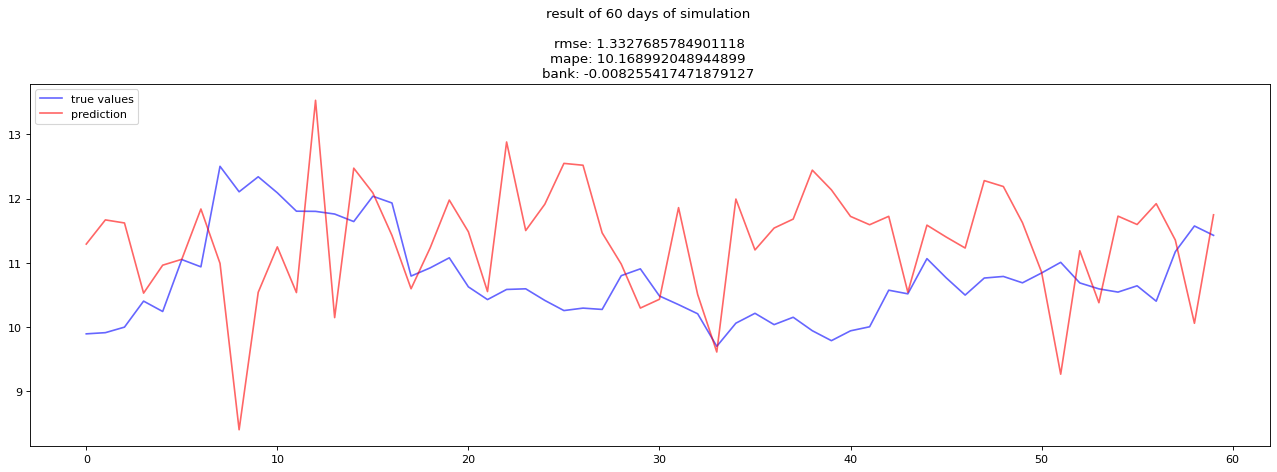

In [27]:
full_result(true_values,predict_values)

